In [14]:
getwd()

[1] "/home/amassara/cmm262-2023/module-9-networks"

In [27]:
# create symlink to input data
system("ln -sfn ~/public/networks data")
# create output directory
system("mkdir -p out/wgnca")

In [16]:
suppressMessages(library(WGCNA))

In [17]:
# We will analyze microarray expression data from the livers of female F2 intercross mice

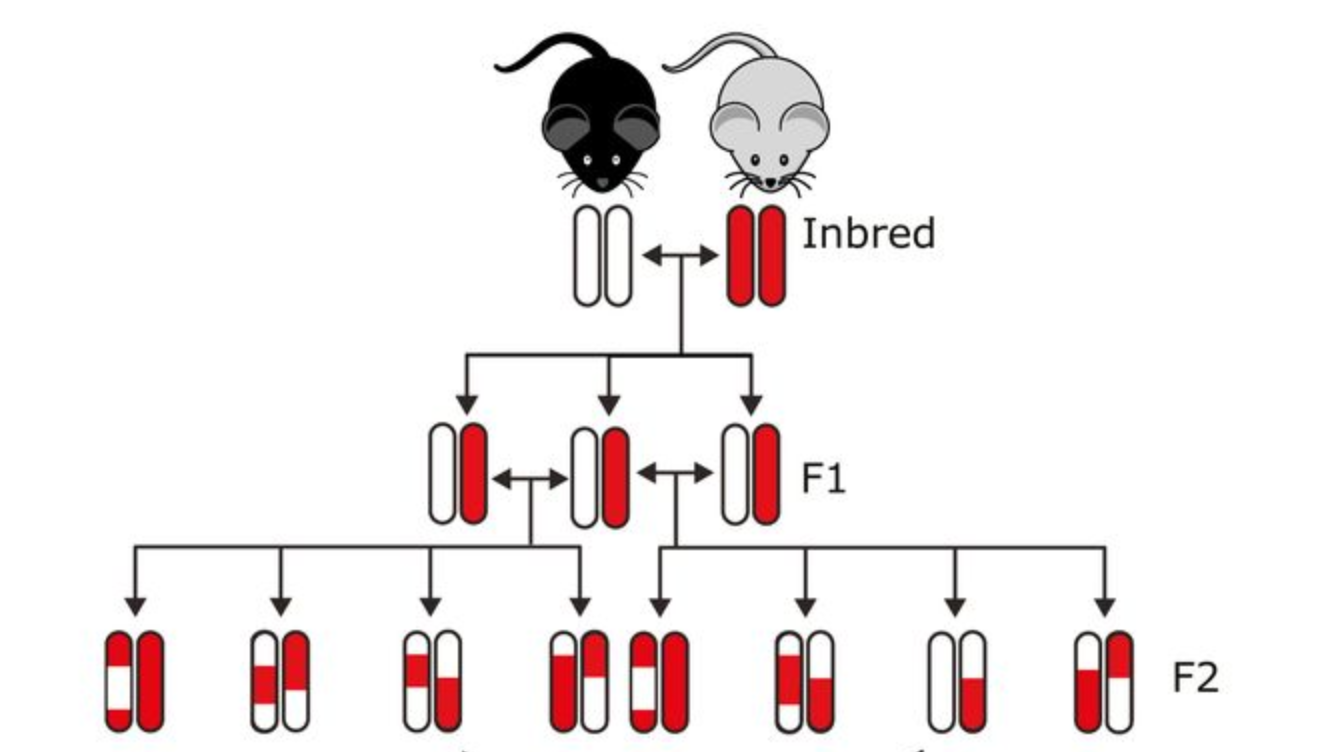

In [18]:
# Load data - file contains expression levels of the top 3600 most variably expressed and most conntected genes
femData = read.csv("data/wgnca/FemaleLiver-Data/LiverFemale3600.csv")
# Summary of dataset
dim(femData)
#names(femData)

[1] 3600  143

In [19]:
# Here's what the data look like
# Each row is a gene
# Columns 1-8 are metadata, 9+ are the gene expression values in the 135 mice

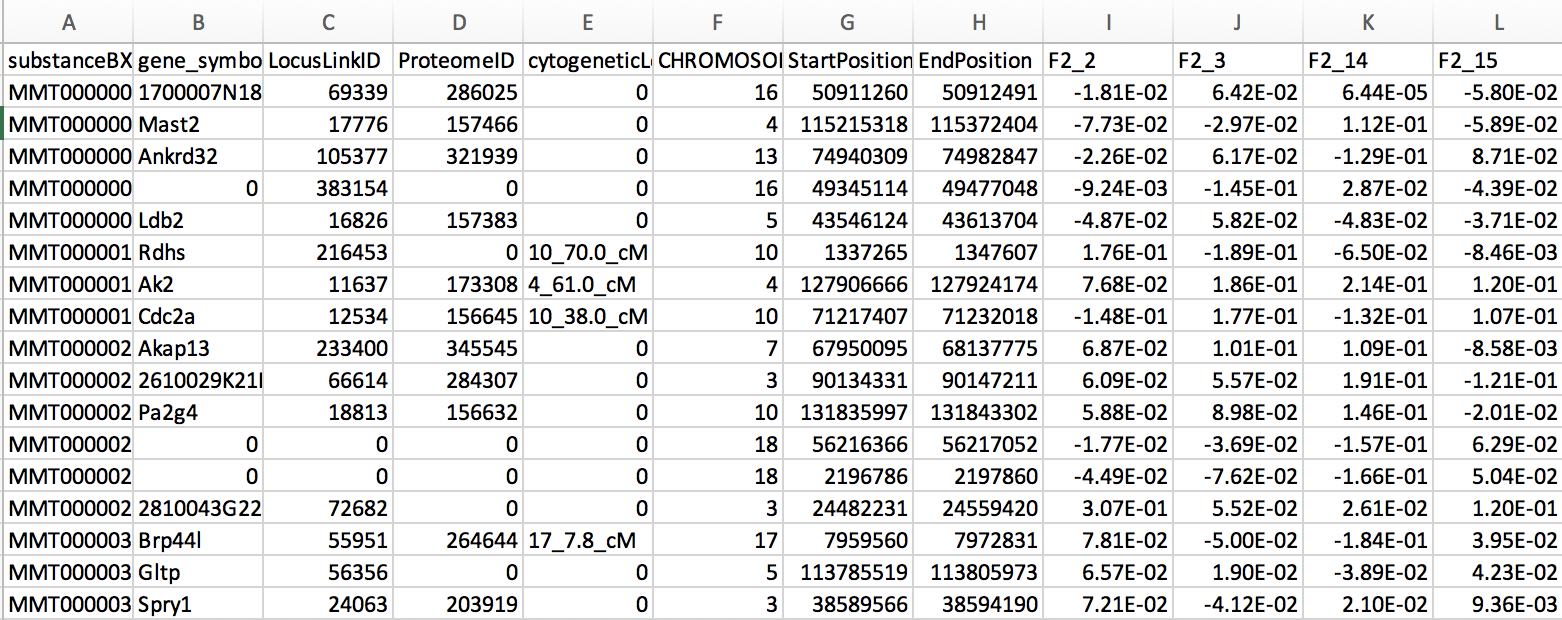

In [6]:
# Put everything after the metadata into a data frame and update the row and column names
# Note that the data are transposed such that rows are now mice and columns are genes
datExpr0 = as.data.frame(t(femData[, -c(1:8)]))
names(datExpr0) = femData$substanceBXH
rownames(datExpr0) = names(femData)[-c(1:8)]
head(datExpr0)

,MMT00000044,MMT00000046,MMT00000051,MMT00000076,MMT00000080,MMT00000102,MMT00000149,MMT00000159,MMT00000207,MMT00000212,⋯,MMT00082822,MMT00082828,MMT00082829,MMT00082832,MMT00082847,MMT00082850,MMT00082869,MMT00082877,MMT00082899,MMT00082906
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F2_2,-0.0181000,-0.0773,-0.02260000,-0.00924,-0.04870000,0.17600000,0.07680000,-0.14800000,0.06870000,0.06090000,⋯,0.0135000,-0.15400000,-0.0218000,0.0310000,0.1290000,0.0467000,0.00991000,0.0291000,-0.00927,0.0436000
F2_3,0.0642000,-0.0297,0.06170000,-0.14500,0.05820000,-0.18900000,0.18600000,0.17700000,0.10100000,0.05570000,⋯,-0.0097100,-0.07410000,0.0900000,0.0106000,0.1130000,-0.0252000,0.03190000,0.0408000,-0.12100,0.0827000
F2_14,0.0000644,0.1120,-0.12900000,0.02870,-0.04830000,-0.06500000,0.21400000,-0.13200000,0.10900000,0.19100000,⋯,0.0709000,-0.13900000,0.0277000,-0.1310000,0.2550000,-0.1230000,0.08800000,0.0892000,-0.11400,-0.0872000
F2_15,-0.0580000,-0.0589,0.08710000,-0.04390,-0.03710000,-0.00846000,0.12000000,0.10700000,-0.00858000,-0.12100000,⋯,-0.0313000,-0.07250000,0.0178000,0.0882000,0.0790000,0.0002760,-0.04820000,0.0493000,-0.05010,-0.0390000
F2_19,0.0483000,0.0443,-0.11500000,0.00425,0.02510000,-0.00574000,0.02100000,-0.11900000,0.10500000,0.05410000,⋯,0.0695000,-0.11500000,0.0618000,0.2950000,0.1270000,-0.0560000,-0.02890000,-0.0389000,0.00718,0.0710000
F2_20,-0.1519741,-0.0938,-0.06502607,-0.23610,0.08504274,-0.01807182,0.06222751,-0.05497686,-0.02441415,0.06343181,⋯,0.1743492,-0.09405315,0.1176646,0.1161963,0.1180381,-0.1171272,-0.09774204,-0.0745188,0.31857,0.2047701


In [7]:
# WGNCA package built in function to evaluate missing values
gsg = goodSamplesGenes(datExpr0, verbose = 3)
gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

In [8]:
# Remove any low coverage genes or samples
if (!gsg$allOK)
{
  # Print the gene and sample names that were removed:
  if (sum(!gsg$goodGenes)>0) 
     printFlush(paste("Removing genes:", paste(names(datExpr0)[!gsg$goodGenes], collapse = ", ")))
  if (sum(!gsg$goodSamples)>0) 
     printFlush(paste("Removing samples:", paste(rownames(datExpr0)[!gsg$goodSamples], collapse = ", ")))
  # Remove the offending genes and samples from the data:
  datExpr0 = datExpr0[gsg$goodSamples, gsg$goodGenes]
}

In [9]:
dim(datExpr0)

[1]  135 3600

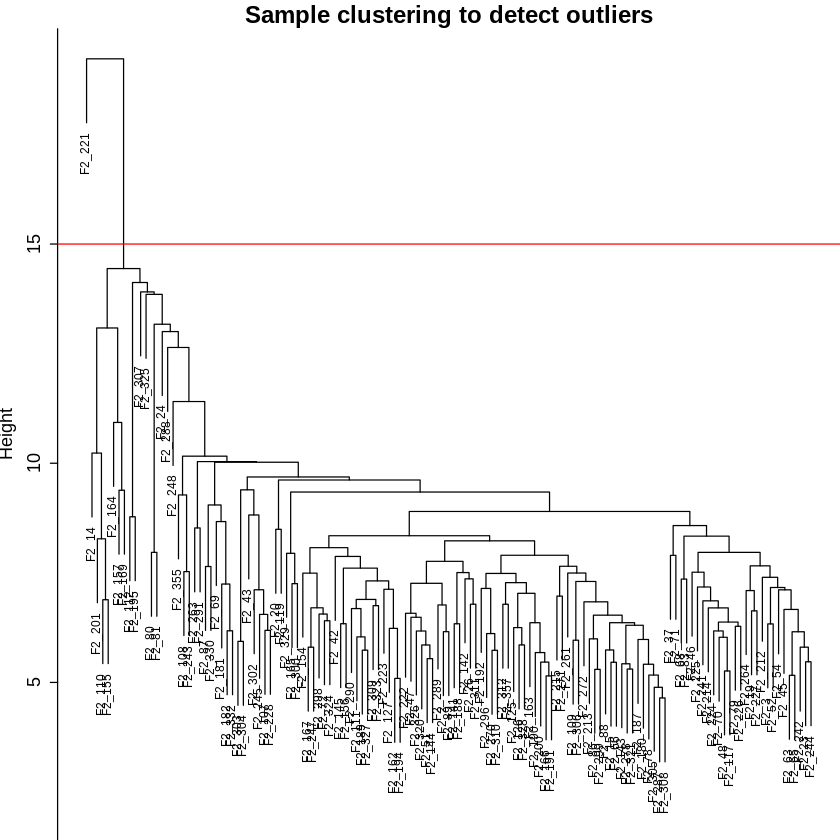

In [10]:
# Evaluate sample clustering on the basis of the 3600 genes
sampleTree = hclust(dist(datExpr0), method = "average")
# Plot the sample tree: Open a graphic output window of size 12 by 9 inches
# The user should change the dimensions if the window is too large or too small.
#sizeGrWindow(12,9)
#pdf(file = "Plots/sampleClustering.pdf", width = 12, height = 9);
par(cex = 0.6)
par(mar = c(0,4,2,0))
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="", cex.lab = 1.5, cex.axis = 1.5, cex.main = 2)
# Plot a line to show the cut
abline(h = 15, col = "red");

In [11]:
# We want to remove the one outlier sample from the dataset
# Determine cluster under the line
clust = cutreeStatic(sampleTree, cutHeight = 15, minSize = 10)
table(clust)
# clust 1 contains the samples we want to keep.
keepSamples = (clust==1)
datExpr = datExpr0[keepSamples, ]
nGenes = ncol(datExpr)
nSamples = nrow(datExpr)

clust
  0   1 
  1 134 

In [20]:
# Load and clean the phenotype data
traitData = read.csv("data/wgnca/FemaleLiver-Data/ClinicalTraits.csv");
dim(traitData)
names(traitData)

# remove columns that hold information we do not need.
allTraits = traitData[, -c(31, 16)];
allTraits = allTraits[, c(2, 11:36) ];
dim(allTraits)
names(allTraits)

# Form a data frame analogous to expression data that will hold the clinical traits.
femaleSamples = rownames(datExpr);
traitRows = match(femaleSamples, allTraits$Mice);
datTraits = allTraits[traitRows, -1];
rownames(datTraits) = allTraits[traitRows, 1];

collectGarbage();
head(datTraits)
str(datTraits)

[1] 361  38

[1] "X"                  "Mice"               "Number"            
 [4] "Mouse_ID"           "Strain"             "sex"               
 [7] "DOB"                "parents"            "Western_Diet"      
[10] "Sac_Date"           "weight_g"           "length_cm"         
[13] "ab_fat"             "other_fat"          "total_fat"         
[16] "comments"           "X100xfat_weight"    "Trigly"            
[19] "Total_Chol"         "HDL_Chol"           "UC"                
[22] "FFA"                "Glucose"            "LDL_plus_VLDL"     
[25] "MCP_1_phys"         "Insulin_ug_l"       "Glucose_Insulin"   
[28] "Leptin_pg_ml"       "Adiponectin"        "Aortic.lesions"    
[31] "Note"               "Aneurysm"           "Aortic_cal_M"      
[34] "Aortic_cal_L"       "CoronaryArtery_Cal" "Myocardial_cal"    
[37] "BMD_all_limbs"      "BMD_femurs_only"

[1] 361  27

[1] "Mice"               "weight_g"           "length_cm"         
 [4] "ab_fat"             "other_fat"          "total_fat"         
 [7] "X100xfat_weight"    "Trigly"             "Total_Chol"        
[10] "HDL_Chol"           "UC"                 "FFA"               
[13] "Glucose"            "LDL_plus_VLDL"      "MCP_1_phys"        
[16] "Insulin_ug_l"       "Glucose_Insulin"    "Leptin_pg_ml"      
[19] "Adiponectin"        "Aortic.lesions"     "Aneurysm"          
[22] "Aortic_cal_M"       "Aortic_cal_L"       "CoronaryArtery_Cal"
[25] "Myocardial_cal"     "BMD_all_limbs"      "BMD_femurs_only"

,weight_g,length_cm,ab_fat,other_fat,total_fat,X100xfat_weight,Trigly,Total_Chol,HDL_Chol,UC,⋯,Leptin_pg_ml,Adiponectin,Aortic.lesions,Aneurysm,Aortic_cal_M,Aortic_cal_L,CoronaryArtery_Cal,Myocardial_cal,BMD_all_limbs,BMD_femurs_only
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
F2_2,38.0,10.5,3.81,2.78,6.59,17.342105,14,1646,34,668,⋯,NA,NA,224500,56,5,0,0,0,NA,NA
F2_3,33.5,10.8,1.70,2.05,3.75,11.194030,109,1216,27,402,⋯,15148.76,14.339,296250,8,4,NA,0,0,NA,NA
F2_14,33.9,10.0,1.29,1.67,2.96,8.731563,2,834,17,354,⋯,6188.74,15.439,486313,27,12,NA,1,8,NA,NA
F2_15,44.3,10.3,3.62,3.34,6.96,15.711061,71,1565,41,536,⋯,18400.26,11.124,180750,0,0,NA,0,4,NA,NA
F2_19,32.9,9.7,2.08,1.85,3.93,11.945289,55,1060,41,411,⋯,8438.70,16.842,113000,0,0,NA,0,0,NA,NA
F2_20,44.8,10.3,3.72,3.20,6.92,15.446429,34,1172,39,448,⋯,41801.54,13.498,166750,6,0,NA,0,0,NA,NA


'data.frame':	134 obs. of  26 variables:
 $ weight_g          : num  38 33.5 33.9 44.3 32.9 44.8 36.9 39.5 42.5 25.7 ...
 $ length_cm         : num  10.5 10.8 10 10.3 9.7 10.3 10 10 9.9 9.4 ...
 $ ab_fat            : num  3.81 1.7 1.29 3.62 2.08 3.72 2.07 2.79 2.68 0.42 ...
 $ other_fat         : num  2.78 2.05 1.67 3.34 1.85 3.2 2.8 2.62 4.56 0.6 ...
 $ total_fat         : num  6.59 3.75 2.96 6.96 3.93 6.92 4.87 5.41 7.24 1.02 ...
 $ X100xfat_weight   : num  17.34 11.19 8.73 15.71 11.95 ...
 $ Trigly            : int  14 109 2 71 55 34 198 186 357 109 ...
 $ Total_Chol        : int  1646 1216 834 1565 1060 1172 1530 1434 1758 1305 ...
 $ HDL_Chol          : int  34 27 17 41 41 39 36 23 56 23 ...
 $ UC                : int  668 402 354 536 411 448 636 517 644 443 ...
 $ FFA               : int  132 96 98 111 115 111 161 122 169 97 ...
 $ Glucose           : int  499 397 424 557 382 456 541 465 663 430 ...
 $ LDL_plus_VLDL     : int  1612 1189 817 1524 1019 1133 1494 1411 1702 1282 ...


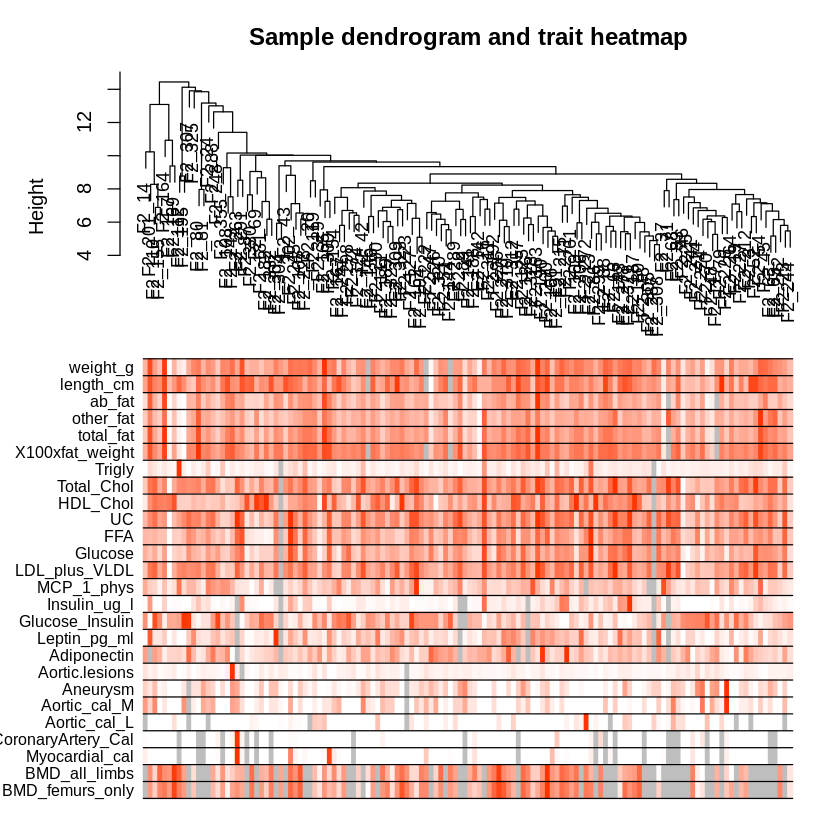

In [21]:
# Visually summarize trait data w.r.t. to sample similarity
# Re-cluster samples (since we removed one)
sampleTree2 = hclust(dist(datExpr), method = "average")
# Convert traits to a color representation: white means low, red means high, grey means missing entry
# If you do this with your own data you may need to check what the trait values are stored as using e.g. str()
traitColors = numbers2colors(datTraits, signed = FALSE);
# Plot the sample dendrogram and the colors underneath.
plotDendroAndColors(sampleTree2, traitColors, groupLabels = names(datTraits), main = "Sample dendrogram and trait heatmap")

In [29]:
system("mkdir -p out/wgnca/FemaleLiver-Data")
save(datExpr, datTraits, file = "out/wgnca/FemaleLiver-Data/FemaleLiver-01-dataInput.RData")

In [30]:
options(stringsAsFactors = FALSE);
# Allow multi-threading within WGCNA. This helps speed up certain calculations.
# At present this call is necessary for the code to work.
# Any error here may be ignored but you may want to update WGCNA if you see one.
# Caution: skip this line if you run RStudio or other third-party R environments. 
# See note above.
enableWGCNAThreads()


Allowing parallel execution with up to 127 working processes.


In [31]:
# WGCNA uses soft thresholding to convert gene co-expression (based on Pearson correlation) to an adjacency matrix
# This involves choosing a threshold parameter that results in a scale free network topology

# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to=20, by=2))
# Call the network topology analysis function
sft = pickSoftThreshold(datExpr, powerVector = powers, verbose = 5)


pickSoftThreshold: will use block size 3600.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 3600 of 3600
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.0278  0.345          0.456  747.00  762.0000 1210.0
2      2   0.1260 -0.597          0.843  254.00  251.0000  574.0
3      3   0.3400 -1.030          0.972  111.00  102.0000  324.0
4      4   0.5060 -1.420          0.973   56.50   47.2000  202.0
5      5   0.6810 -1.720          0.940   32.20   25.1000  134.0
6      6   0.9020 -1.500          0.962   19.90   14.5000   94.8
7      7   0.9210 -1.670          0.917   13.20    8.6800   84.1
8      8   0.9040 -1.720          0.876    9.25    5.3900   76.3
9      9   0.8590 -1.700          0.836    6.80    3.5600   70.5
10    10   0.8330 -1.660          0.831    5.19    2.3800   65.8
11    12   0.8530 -1.480          0.911    3.33    1.1500   58.1
12    14   0.8760 -1.380          0.949    2.35    0.5740   51.9


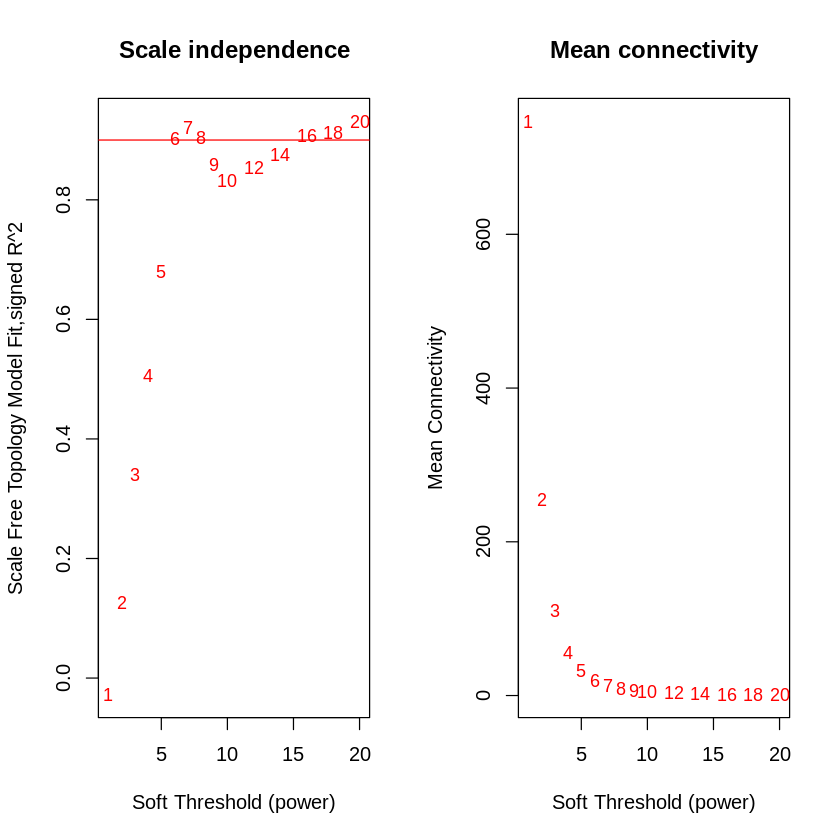

In [32]:
# Plot the results:
#sizeGrWindow(9, 5)
par(mfrow = c(1,2));
cex1 = 0.9;
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.90,col="red")
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

In [33]:
# In the above plot, a power parameter of 6 gives the best tradeoff  
# between a scale free topology and a high mean conntectivity
# WGNCA next identifies network modules based on similarity obtained from the Topological Overlap Matrix (TOM)
# Similarity is converted to a distance by subtracting it from 1, and the distance allows use of a dendrogram to 
# define modules
net = blockwiseModules(datExpr, power = 6,
                       TOMType = "unsigned", minModuleSize = 30,
                       reassignThreshold = 0, mergeCutHeight = 0.25,
                       numericLabels = TRUE, pamRespectsDendro = FALSE,
                       saveTOMs = TRUE,
                       saveTOMFileBase = "out/wgnca/femaleMouseTOM", 
                       verbose = 3)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
Cluster size 3600 broken into 2108 1492 
Cluster size 2108 broken into 1126 982 
Done cluster 1126 
Done cluster 982 
Done cluster 2108 
Done cluster 1492 
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 127 parallel threads.
     Fraction of slow calculations: 0.363818
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file femaleMouseTOM-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 1 genes from module 1 because their KME is too low.
     ..removing 1 genes from module 7 because their KME is too low.
     ..removing 1 genes from module 8 because their KME is too low.
     ..removing 1 genes from module 21 because their KME is too low.
 ..merging modules that

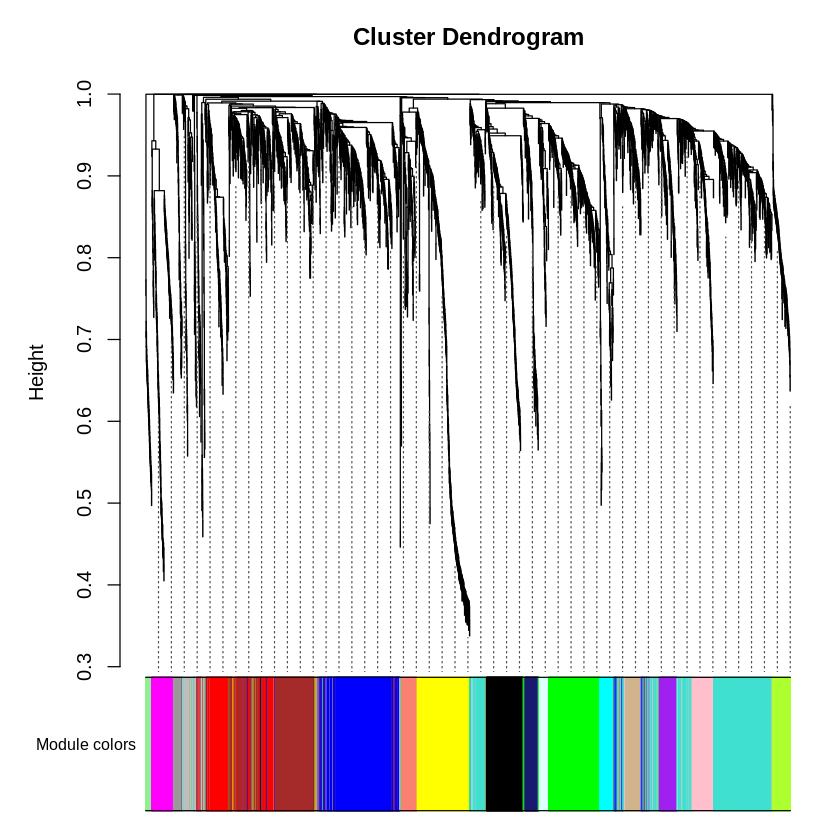

In [34]:
# We can visualize the results by clustering genes based on their TOM distance 
# and coloring by gene modules inferred by WGNCA
# open a graphics window
#sizeGrWindow(12, 9)
# Convert labels to colors for plotting
mergedColors = labels2colors(net$colors)
# Plot the dendrogram and the module colors underneath
plotDendroAndColors(net$dendrograms[[1]], mergedColors[net$blockGenes[[1]]],
                    "Module colors",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

In [36]:
# Label modules according to their color name
# MEs = module eigengenes (first principal component within a module)
# MEs can be used to evaluate how related modules are
moduleLabels = net$colors
moduleColors = labels2colors(net$colors)
MEs = net$MEs
geneTree = net$dendrograms[[1]];
save(MEs, moduleLabels, moduleColors, geneTree, 
     file = "out/wgnca/FemaleLiver-Data/FemaleLiver-02-networkConstruction-auto.RData")

In [37]:
# Define numbers of genes and samples
nGenes = ncol(datExpr);
nSamples = nrow(datExpr);
# Recalculate MEs with color labels (gives gene x module color PC1 loading matrix)
MEs0 = moduleEigengenes(datExpr, moduleColors)$eigengenes
MEs = orderMEs(MEs0)
# Correlate within-module PC1 with trait values
moduleTraitCor = cor(MEs, datTraits, use = "p");
moduleTraitPvalue = corPvalueStudent(moduleTraitCor, nSamples);

Warning message in greenWhiteRed(50):
“WGCNA::greenWhiteRed: this palette is not suitable for people
with green-red color blindness (the most common kind of color blindness).
Consider using the function blueWhiteRed instead.”


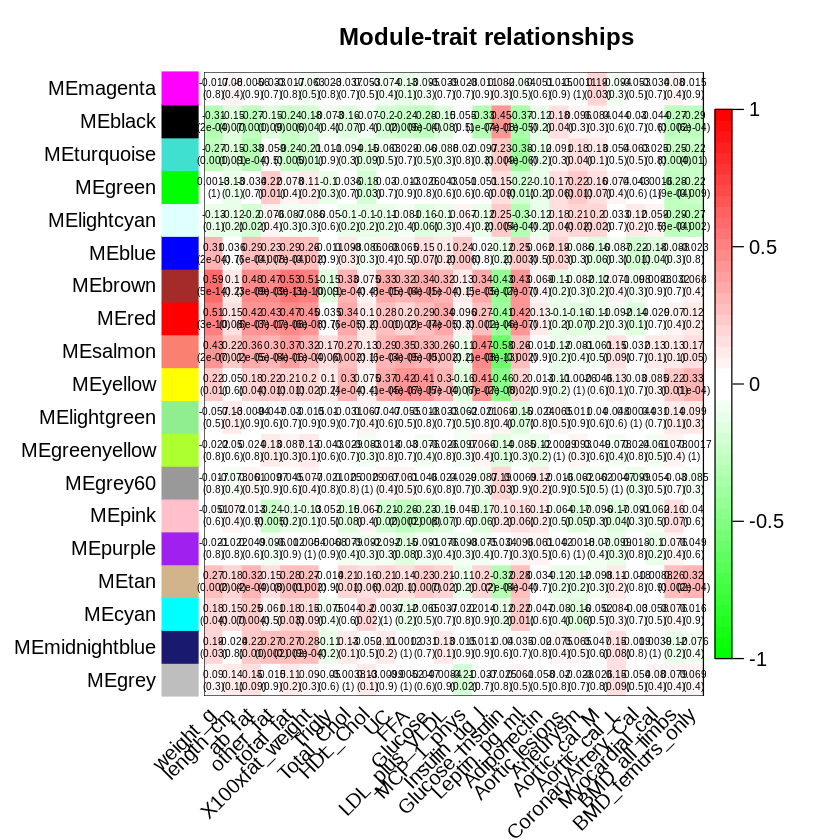

In [38]:
# Visualize the relationship between modules and traits
# Useful for selecting modules you'd like to investigate further
#sizeGrWindow(10,6)
# Will display correlations and their p-values
textMatrix =  paste(signif(moduleTraitCor, 2), "\n(",signif(moduleTraitPvalue, 1), ")", sep = "");
dim(textMatrix) = dim(moduleTraitCor)
par(mar = c(6, 8.5, 3, 3));
# Display the correlation values within a heatmap plot
labeledHeatmap(Matrix = moduleTraitCor,
               xLabels = names(datTraits),
               yLabels = names(MEs),
               ySymbols = names(MEs),
               colorLabels = FALSE,
               colors = greenWhiteRed(50),
               textMatrix = textMatrix,
               setStdMargins = FALSE,
               cex.text = 0.5,
               zlim = c(-1,1),
               main = paste("Module-trait relationships"))

In [39]:
# Look at modules/genes that are significantly associated with weight

# Define variable weight containing the weight column of datTrait
weight = as.data.frame(datTraits$weight_g)
names(weight) = "weight"
# names (colors) of the modules
modNames = substring(names(MEs), 3)

# Gene module membership is evaluated based on cross correlation between gene expression values and module loadings
geneModuleMembership = as.data.frame(cor(datExpr, MEs, use = "p"))
MMPvalue = as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples))

names(geneModuleMembership) = paste("MM", modNames, sep="")
names(MMPvalue) = paste("p.MM", modNames, sep="")

# Get significance of gene expression correlation with trait
geneTraitSignificance = as.data.frame(cor(datExpr, weight, use = "p"))
GSPvalue = as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples))

names(geneTraitSignificance) = paste("GS.", names(weight), sep="")
names(GSPvalue) = paste("p.GS.", names(weight), sep="")

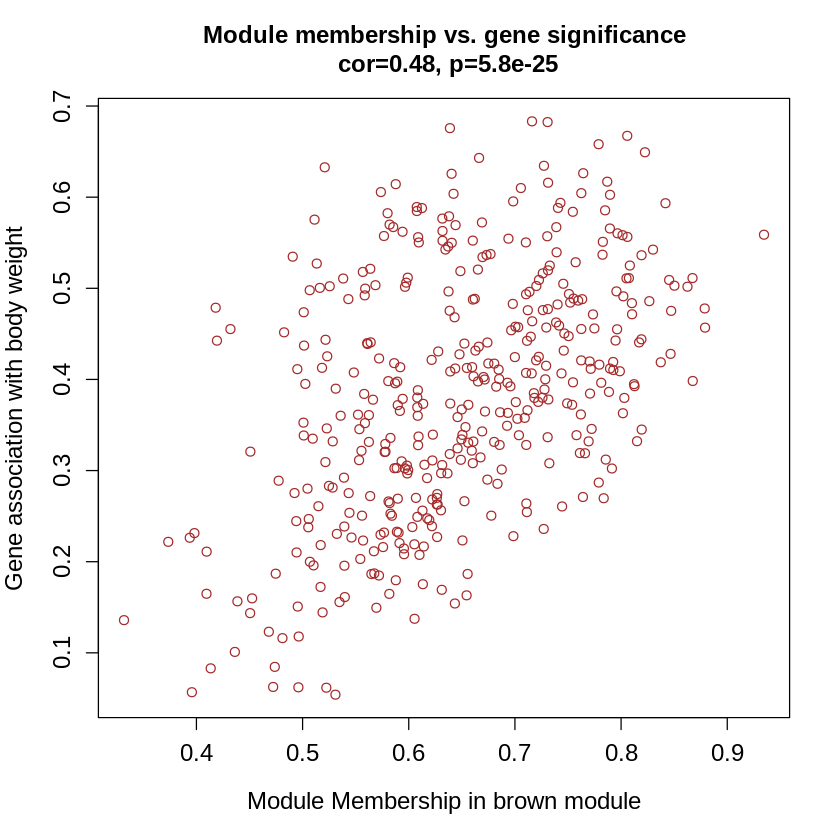

In [40]:
# You can visualize the relationship between a gene's membership in a module and its association with a trait
# Here genes that drive the identitity of the brown module are also more significantly associated with weight
module = "brown"
column = match(module, modNames);
moduleGenes = moduleColors==module;

#summary(geneTraitSignificance[moduleGenes, 1])

#sizeGrWindow(7, 7);
par(mfrow = c(1,1));
verboseScatterplot(abs(geneModuleMembership[moduleGenes, column]),
                   abs(geneTraitSignificance[moduleGenes, 1]),
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene association with body weight",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)



In [41]:
# Gene membership in the brown module
head(names(datExpr)[moduleColors=="brown"])
length(names(datExpr)[moduleColors=="brown"])

[1] "MMT00000887" "MMT00001077" "MMT00001185" "MMT00001486" "MMT00002002"
[6] "MMT00002037"

[1] 409

In [44]:
# Next we will update the gene names with mappings from probes to genes
annot = read.csv(file = "data/wgnca/FemaleLiver-Data/GeneAnnotation.csv");
dim(annot)
#names(annot)
head(annot)
probes = names(datExpr)
probes2annot = match(probes, annot$substanceBXH)
# The following is the number or probes without annotation:
sum(is.na(probes2annot))
# Should return 0.

[1] 23388    34

,X,ID,arrayname,substanceBXH,gene_symbol,LocusLinkID,OfficialGeneSymbol,OfficialGeneName,LocusLinkSymbol,LocusLinkName,⋯,reporterid,probeid,sequenceid,clusterid,chromosome,startcoordinate,endcoordinate,strand,sequence_3_to_5_prime,sequence_5_to_3_prime
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>
1,1,20709,Mouse TOE 75k Array 1,MMT00000003,NA,NA,NA,NA,NA,NA,⋯,10024402482,175683291,16579007,282224,16,43949221,43954881,-1,GTCTGTGTTACTACCAGGTAAGAGGCATGTGTCTATGGCGTATAGGCCGTTACGGTACGG,GGCATGGCATTGCCGGATATGCGGTATCTGTGTACGGAGAATGGACCATCATTGTGTCTG
2,2,7106,Mouse TOE 75k Array 1,MMT00000004,NA,385492,NA,NA,NA,similar to P38IP protein,⋯,10024402217,175683572,14231140,421008,X,83655591,83660848,-1,CCACCGTTTACACTGGTCGTACGAACTTCCTCCAGTTTAGAAACATGACCGGTGAGCACA,ACACGAGTGGCCAGTACAAAGATTTGACCTCCTTCAAGCATGCTGGTCACATTTGCCACC
3,3,8193,Mouse TOE 75k Array 1,MMT00000006,Zfp262,67785,Zfp262,zinc finger protein 262,NA,NA,⋯,10024408822,175677005,14335389,221540,4,125835590,125861853,-1,TGATAATATATAAGTAACAAATTTAGGGAAGGATGTAAAGTGTCATTGATGTCGGGCGTC,CTGCGGGCTGTAGTTACTGTGAAATGTAGGAAGGGATTTAAACAATGAATATATAATAGT
4,4,21563,Mouse TOE 75k Array 1,MMT00000007,Slc25a27,74011,Slc25a27,"solute carrier family 25, member 27",NA,NA,⋯,10024405962,175679831,16771714,287436,17,43034644,43059759,-1,TTGTAATCTTTTGTATCTTTTTGGTTTTAGAGGGGGTTTCACTAAAACAAACACCTCGTC,CTGCTCCACAAACAAAATCACTTTGGGGGAGATTTTGGTTTTTCTATGTTTTCTAATGTT
5,5,17750,Mouse TOE 75k Array 1,MMT00000014,Mrpl45,67036,Mrpl45,mitochondrial ribosomal protein L45,NA,NA,⋯,10024403043,175682760,15901627,264295,11,96900503,96910500,1,GGTGTAAGAAAGAGTAGCTAGTCAAGAGACACAGTCAGGAAGGAGACTTTCTCTACTGTA,ATGTCATCTCTTTCAGAGGAAGGACTGACACAGAGAACTGATCGATGAGAAAGAATGTGG
6,6,21545,Mouse TOE 75k Array 1,MMT00000015,2310015N21Rik,76438,2310015N21Rik,RIKEN cDNA 2310015N21 gene,NA,NA,⋯,10024402614,175683189,16767829,287350,17,49447490,49644180,-1,TCTCTTTTCTTGTCTGTTAAAATGAATGTAATTTGTACCTCAGGTACCTACCTTTCCGTA,ATGCCTTTCCATCCATGGACTCCATGTTTAATGTAAGTAAAATTGTCTGTTCTTTTCTCT


[1] 0

In [45]:
# Create a new data frame to store gene information
geneInfo0 = data.frame(substanceBXH = probes,
                      geneSymbol = annot$gene_symbol[probes2annot],
                      LocusLinkID = annot$LocusLinkID[probes2annot],
                      moduleColor = moduleColors,
                      geneTraitSignificance,
                      GSPvalue)
# Order modules by their significance for weight
modOrder = order(-abs(cor(MEs, weight, use = "p")));
# Add module membership information in the chosen order
for (mod in 1:ncol(geneModuleMembership))
{
  oldNames = names(geneInfo0)
  geneInfo0 = data.frame(geneInfo0, geneModuleMembership[, modOrder[mod]], 
                         MMPvalue[, modOrder[mod]]);
  names(geneInfo0) = c(oldNames, paste("MM.", modNames[modOrder[mod]], sep=""),
                       paste("p.MM.", modNames[modOrder[mod]], sep=""))
}
# Order the genes in the geneInfo variable first by module color, then by geneTraitSignificance
geneOrder = order(geneInfo0$moduleColor, -abs(geneInfo0$GS.weight));
geneInfo = geneInfo0[geneOrder, ]

In [46]:
head(geneInfo)
write.csv(geneInfo, file = "out/wgnca/FemaleLiver-Data/geneInfo.csv")

,substanceBXH,geneSymbol,LocusLinkID,moduleColor,GS.weight,p.GS.weight,MM.brown,p.MM.brown,MM.red,p.MM.red,⋯,MM.greenyellow,p.MM.greenyellow,MM.purple,p.MM.purple,MM.magenta,p.MM.magenta,MM.grey60,p.MM.grey60,MM.green,p.MM.green
,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MMT00030014,MMT00030014,9130422G05Rik,66819,black,-0.5797950,2.125494e-13,-0.5551214,3.387107e-12,-0.5518715,4.796555e-12,⋯,0.08515411,0.3279391,-0.0001808971,0.99834486,-0.02324890,0.7897463,0.098817162,0.2559744,0.4390999,1.111879e-07
MMT00035294,MMT00035294,BC010552,213603,black,0.4608253,2.106843e-08,0.5056431,4.616811e-10,0.5198128,1.224257e-10,⋯,0.06052297,0.4872574,0.1680142302,0.05231873,0.01975180,0.8207942,-0.005150742,0.9528996,-0.5271016,6.037282e-11
MMT00074983,MMT00074983,Gpx4,14779,black,0.4432473,8.165953e-08,0.5950928,3.387327e-14,0.6369651,1.304026e-16,⋯,-0.01677004,0.8474899,-0.0206252821,0.81301115,-0.05260653,0.5460579,-0.047756846,0.5837200,-0.3844214,4.522836e-06
MMT00030149,MMT00030149,Gpx4,14779,black,0.4189853,4.692800e-07,0.5693519,7.056051e-13,0.6198797,1.393559e-15,⋯,-0.01273465,0.8838905,-0.0019002493,0.98261474,-0.03843569,0.6592709,-0.051816210,0.5521134,-0.4043207,1.266045e-06
MMT00007987,MMT00007987,Gpx4,14779,black,0.4094111,9.018789e-07,0.5513512,5.069532e-12,0.5581619,2.437694e-12,⋯,-0.02529043,0.7717691,-0.0361345787,0.67850459,-0.04574199,0.5997112,-0.069949745,0.4219024,-0.4171338,5.333181e-07
MMT00042811,MMT00042811,Pigr,18703,black,-0.4016482,1.509430e-06,-0.4812277,3.961161e-09,-0.5323974,3.573865e-11,⋯,0.03635921,0.6766176,0.1069841155,0.21856127,-0.09018670,0.3000532,0.098222176,0.2588623,0.4907018,1.755006e-09


In [47]:
# Match probes in the data set to the probe IDs in the annotation file 
probes = names(datExpr)
probes2annot = match(probes, annot$substanceBXH)
# Get the corresponding Locuis Link IDs
allLLIDs = annot$LocusLinkID[probes2annot];
# Choose interesting modules
intModules = c("brown", "red", "salmon")
for (module in intModules)
{
  # Select module probes
  modGenes = (moduleColors==module)
  # Get their entrez ID codes
  modLLIDs = allLLIDs[modGenes];
  # Write them into a file
  fileName = paste("out/wgnca/LocusLinkIDs-", module, ".txt", sep="");
  write.table(as.data.frame(modLLIDs), file = fileName,
              row.names = FALSE, col.names = FALSE)
}
# As background in the enrichment analysis, we will use all probes in the analysis.
fileName = paste("out/wgnca/LocusLinkIDs-all.txt", sep="");
write.table(as.data.frame(allLLIDs), file = fileName,
            row.names = FALSE, col.names = FALSE)


In [48]:
# Perform GO enrichment analysis on each module, keeping the top ten annotations
GOenr = suppressMessages(GOenrichmentAnalysis(moduleColors, allLLIDs, organism = "mouse", nBestP = 10))

Warning message in GOenrichmentAnalysis(moduleColors, allLLIDs, organism = "mouse", :
“This function is deprecated and will be removed in the near future. 
We suggest using the replacement function enrichmentAnalysis 
in R package anRichment, available from the following URL:
https://labs.genetics.ucla.edu/horvath/htdocs/CoexpressionNetwork/GeneAnnotation/”
Loading required package: org.Mm.eg.db

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data

 GOenrichmentAnalysis: loading annotation data...
  ..of the 3038  Entrez identifiers submitted, 2831 are mapped in current GO categories.
  ..will use 2831 background genes for enrichment calculations.
  ..preparing term lists (this may take a while).. 
  ..working on label set 1 ..
    ..calculating enrichments (this may also take a while)..
    ..putting together terms with highest enrichment significance..


In [49]:
tab = GOenr$bestPTerms[[4]]$enrichment
names(tab)
write.table(tab, file = "out/wgnca/FemaleLiver-Data/GOEnrichmentTable.csv", sep = ",", quote = TRUE, row.names = FALSE)

[1] "module"             "modSize"            "bkgrModSize"       
 [4] "rank"               "enrichmentP"        "BonferoniP"        
 [7] "nModGenesInTerm"    "fracOfBkgrModSize"  "fracOfBkgrTermSize"
[10] "bkgrTermSize"       "termID"             "termOntology"      
[13] "termName"           "termDefinition"

In [50]:
# Drop columns that are not needed and clean up for visualization
keepCols = c(1, 2, 5, 6, 7, 12, 13);
screenTab = tab[, keepCols];
# Round the numeric columns to 2 decimal places:
numCols = c(3, 4);
screenTab[, numCols] = signif(apply(screenTab[, numCols], 2, as.numeric), 2)
# Truncate the the term name to at most 40 characters
screenTab[, 7] = substring(screenTab[, 7], 1, 40)
# Shorten the column names:
colnames(screenTab) = c("module", "size", "p-val", "Bonf", "nInTerm", "ont", "term name");
rownames(screenTab) = NULL;
# Set the width of R's output. The reader should play with this number to obtain satisfactory output.
options(width=95)
# Finally, display the enrichment table:
screenTab

module,size,p-val,Bonf,nInTerm,ont,term name
<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
black,166,3.9e-04,1.0e+00,4,BP,dopamine transport
black,166,6.5e-04,1.0e+00,5,BP,mRNA transport
black,166,8.0e-04,1.0e+00,6,BP,RNA transport
black,166,8.0e-04,1.0e+00,13,MF,receptor ligand activity
black,166,9.9e-04,1.0e+00,13,MF,receptor regulator activity
black,166,1.0e-03,1.0e+00,6,BP,RNA localization
black,166,1.6e-03,1.0e+00,6,BP,amine transport
black,166,2.4e-03,1.0e+00,6,MF,growth factor activity
black,166,2.6e-03,1.0e+00,2,BP,ventricular compact myocardium morphogen


In [ ]:
# Visualize the network adjacency matrix together with a dendrogram of gene distances and module colors
# Calculate topological overlap distance anew
# We calculated in during module detection, but let's do it again here.
dissTOM = 1-TOMsimilarityFromExpr(datExpr, power = 6);
# Transform dissTOM with a power to make moderately strong connections more visible in the heatmap
plotTOM = dissTOM^7;
# Set diagonal to NA for a nicer plot
diag(plotTOM) = NA;
# Call the plot function
#sizeGrWindow(9,9)
TOMplot(plotTOM, geneTree, moduleColors, main = "Network heatmap plot, all genes")

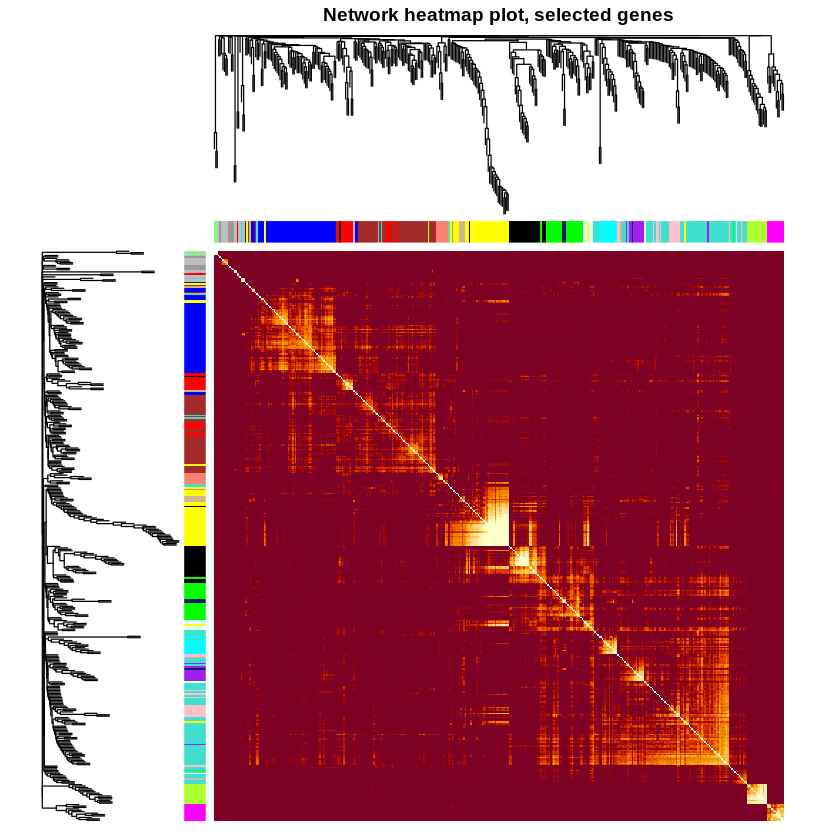

In [52]:
# Revisit with 400 randomly selected genes
# This runs faster than the larger network while returning similar substructure
# It also gives some idea of how robust the solution is
nSelect = 400
# For reproducibility, we set the random seed
set.seed(10);
select = sample(nGenes, size = nSelect);
selectTOM = dissTOM[select, select];
# There's no simple way of restricting a clustering tree to a subset of genes, so we must re-cluster.
selectTree = hclust(as.dist(selectTOM), method = "average")
selectColors = moduleColors[select];
# Open a graphical window
#sizeGrWindow(9,9)
# Taking the dissimilarity to a power, say 10, makes the plot more informative by effectively changing 
# the color palette; setting the diagonal to NA also improves the clarity of the plot
plotDiss = selectTOM^7;
diag(plotDiss) = NA;
TOMplot(plotDiss, selectTree, selectColors, main = "Network heatmap plot, selected genes")

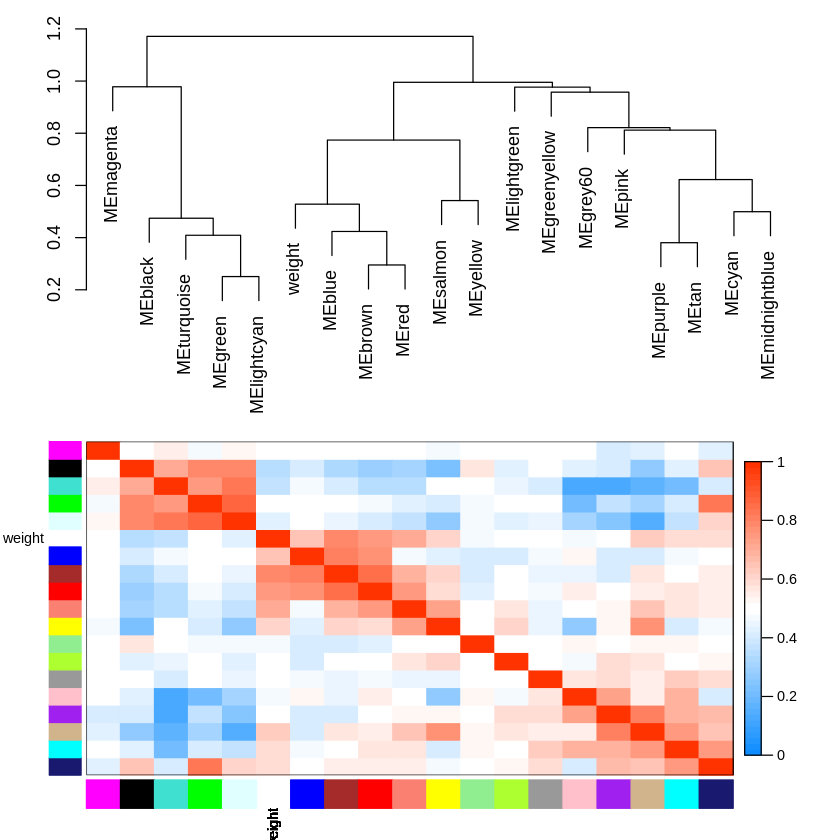

In [53]:
# Visualize similarity of modules based on within module PC1 loadings
# Each mouse has a module eigengene value within each module
# Here, a trait (weight) is included which allows to see which modules correlate most with that trait
# Recalculate module eigengenes
MEs = moduleEigengenes(datExpr, moduleColors)$eigengenes
# Isolate weight from the clinical traits
weight = as.data.frame(datTraits$weight_g);
names(weight) = "weight"
# Add the weight to existing module eigengenes
MET = orderMEs(cbind(MEs, weight))
# Plot the relationships among the eigengenes and the trait
#sizeGrWindow(5,7.5);
par(cex = 0.9)
plotEigengeneNetworks(MET, "", marDendro = c(0,4,1,2), marHeatmap = c(3,4,1,2), cex.lab = 0.8, xLabelsAngle
= 90)

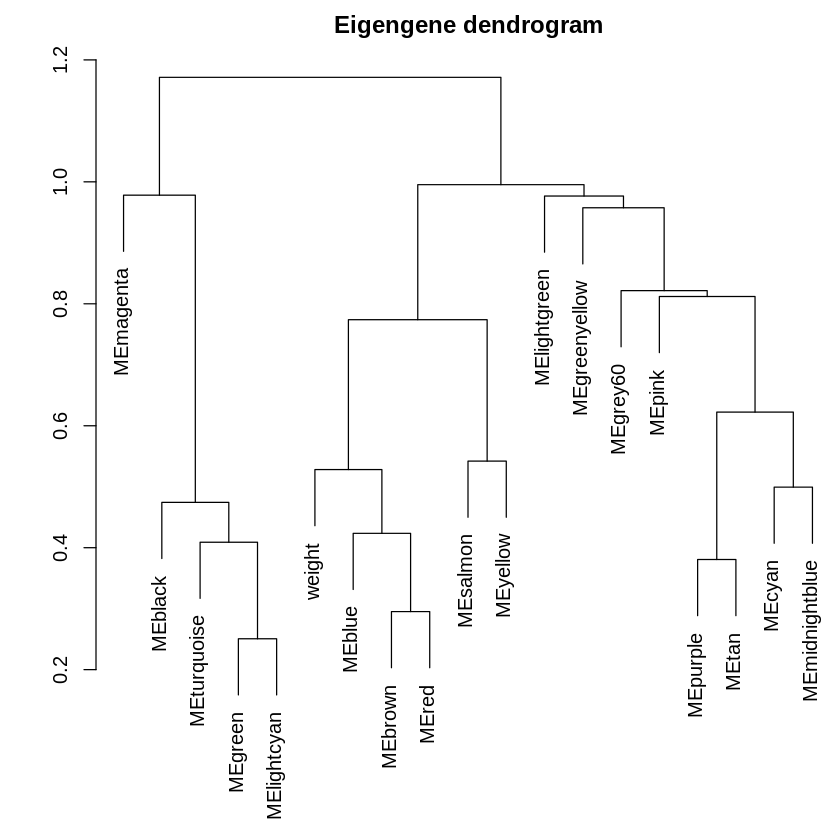

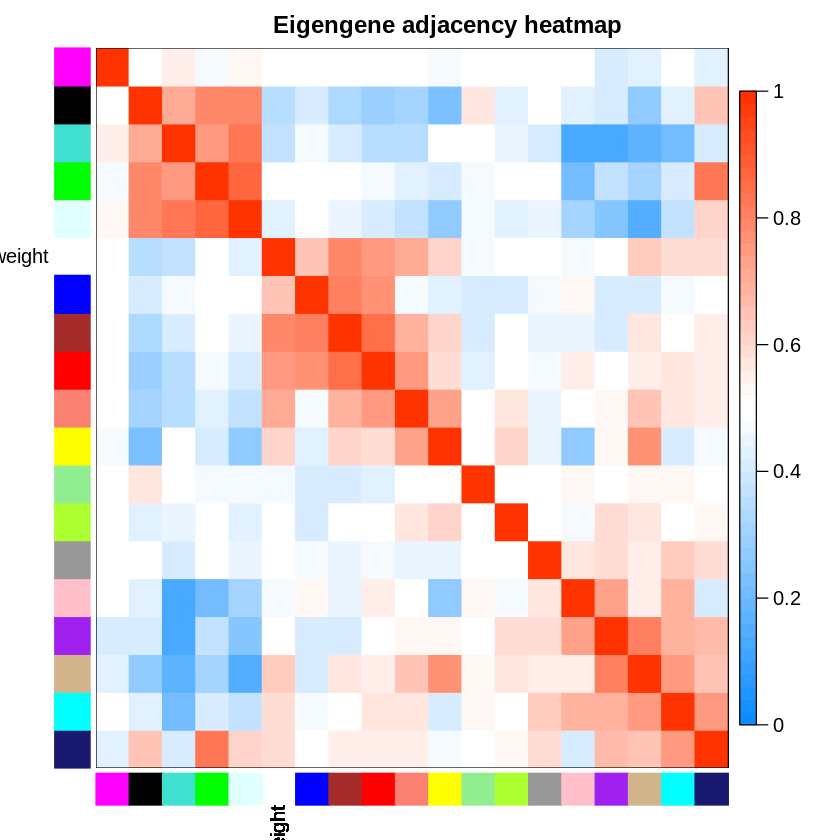

In [54]:
# You can also plot the heatmap and dendrogram separately
# Plot the dendrogram
#sizeGrWindow(6,6);
par(cex = 1.0)
plotEigengeneNetworks(MET, "Eigengene dendrogram", marDendro = c(0,4,2,0),
                      plotHeatmaps = FALSE)
# Plot the heatmap matrix (note: this plot will overwrite the dendrogram plot)
par(cex = 1.0)
plotEigengeneNetworks(MET, "Eigengene adjacency heatmap", marHeatmap = c(3,4,2,2),
                      plotDendrograms = FALSE, xLabelsAngle = 90)

In [55]:
# Now we will prepare the data for visualization with 3rd party tools
# Recalculate topological overlap 
TOM = TOMsimilarityFromExpr(datExpr, power = 6);

TOM calculation: adjacency..
..will use 127 parallel threads.
 Fraction of slow calculations: 0.362157
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [57]:
# Here we generate a file for VisANT from a single module
# Read in the annotation file
annot = read.csv(file = "data/wgnca/FemaleLiver-Data/GeneAnnotation.csv");
# Select module
module = "brown";
# Select module probes
probes = names(datExpr)
inModule = (moduleColors==module);
modProbes = probes[inModule];
# Select the corresponding Topological Overlap
modTOM = TOM[inModule, inModule];
dimnames(modTOM) = list(modProbes, modProbes)
# Export the network into an edge list file VisANT can read
vis = exportNetworkToVisANT(modTOM,
  file = paste("VisANTInput-", module, ".txt", sep=""),
  weighted = TRUE,
  threshold = 0,
  probeToGene = data.frame(annot$substanceBXH, annot$gene_symbol) )

In [58]:
# Export only the top 30 most connected genes in the module for visualization with VisANT software
nTop = 30;
IMConn = softConnectivity(datExpr[, modProbes]);
top = (rank(-IMConn) <= nTop)
vis = exportNetworkToVisANT(modTOM[top, top],
  file = paste("out/wgnca/VisANTInput-", module, "-top30.txt", sep=""),
  weighted = TRUE,
  threshold = 0,
  probeToGene = data.frame(annot$substanceBXH, annot$gene_symbol) )

 softConnectivity: FYI: connecitivty of genes with less than 45 valid samples will be returned as NA.
 ..calculating connectivities.. 


In [59]:
# Export data for visualization with Cytoscape
# Select modules
modules = c("brown", "red");
# Select module probes
probes = names(datExpr)
inModule = is.finite(match(moduleColors, modules));
modProbes = probes[inModule];
modGenes = annot$gene_symbol[match(modProbes, annot$substanceBXH)];
# Select the corresponding Topological Overlap
modTOM = TOM[inModule, inModule];
dimnames(modTOM) = list(modProbes, modProbes)
# Export the network into edge and node list files Cytoscape can read
cyt = exportNetworkToCytoscape(modTOM,
  edgeFile = paste("out/wgnca/CytoscapeInput-edges-", paste(modules, collapse="-"), ".txt", sep=""),
  nodeFile = paste("out/wgnca/CytoscapeInput-nodes-", paste(modules, collapse="-"), ".txt", sep=""),
  weighted = TRUE,
  threshold = 0.02,
  nodeNames = modProbes,
  altNodeNames = modGenes,
  nodeAttr = moduleColors[inModule]);